# SynCOM: Synthetic Corona Outflow Model

<b>SynCOM</b> (Synthetic Corona Outflow Model) is a high-resolution simulation framework designed to model transient solar wind flows in the solar corona. It generates synthetic datasets that mimic the dynamic behavior of solar wind structures, such as plasma blobs, providing a controlled environment for testing and validating flow-tracking algorithms.

### Synthetic Data Generation: 
Simulates solar wind features using radially propagating Gaussian blobs, allowing for the creation of realistic coronal outflow scenarios.
### Modular Design: 
Comprises distinct modules for parameter initialization, profile loading, core simulation, image generation, and visual fidelity enhancements, facilitating flexible and customizable simulations.
### Validation Platform: 
Serves as a benchmark for evaluating the performance of various flow-tracking methods, aiding in the development of more accurate space weather forecasting tools.

## Integration with Python
While SynCOM is originally implemented in IDL, its output datasets (e.g., FITS files) can be seamlessly integrated into Python-based analysis pipelines. Researchers can utilize libraries such as <code>astropy</code>, <code>numpy</code>, and <code>matplotlib</code> to process and visualize SynCOM-generated data, enabling the application of Python-based flow-tracking algorithms for validation and research purposes.​

In [1]:
import numpy as np
import time
from astropy.io import fits
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.io import fits  # required for saving .fts files


# Parameter Initialization

The <code>default_syncom_prams</code> module sets up the core parameters required to run a SynCOM simulation. It initializes values stored in ModPramsStruct, such as:

<ul>
<li><code>nblobs</code>: Number of synthetic solar wind blobs.</li>
<li><code>nθ</code>, <code>nr</code>: Image resolution in position angle and radial distance (defaults match COR2 resolution).</li>
<li><code>r0</code>: Initial radial launch position of blobs.</li>
</ul>

Optional parameters allow finer control:

<ul>
<li><b>Cadence</b>: Time step between frames (e.g., 300s for COR2 special campaigns).</li>
<li><b>Pixel size</b>: 9.744 Mm (≈0.014 R☉ per pixel in deep-field mode).</li>
<li><b>Acceleration</b>, peak brightness, and noise level: Tunable physical properties.</li>
</ul>

These values are informed by observational constraints, particularly from the COR2 instrument aboard the STEREO spacecraft (Howard et al., 2008; Kaiser et al., 2008).

In [2]:
def default_syncom_prams(
    SYNCOM_N_BLOBS=1000,
    SYNCOM_CADENCE=300.0,
    SYNCOM_PIXEL=0.014,
    SYNCOM_NX=3600,
    SYNCOM_NY=659,
    SYNCOM_ACC=0,
    SYNCOM_SCALE_FACTOR=1.0,
    SYNCOM_INITIAL_R_SUN=1.0,
    SYNCOM_NOISE_LEVEL=0.0,
    SYNCOM_MAX_INTENSITY=1.0e-14,
    SYNCOM_TIME=0.0,
    SYNCOMFILE=None,
    DATE=None,
    SAVEPRAMS=None,
    WORKING_DIR=None
):
    from pathlib import Path
    default_file = "syncom_20140414_densfix.sav"
    if SYNCOMFILE:
        syncomfile = SYNCOMFILE
    elif DATE:
        syncomfile = f"syncom_{DATE.replace('-', '')}_densfix.sav"
    else:
        print("No file or date entered. Using default:", default_file)
        syncomfile = default_file

    now = DATE if DATE else "2014-04-14"
    exlab = f"observer date={now}"
    label = f"SynCOM model, cube={now}\n{exlab}"
    name = "syncom"
    
    pram_dict = {
        "Name": name,
        "Label": label,
        "filename": str(Path.home() / "stereo_analysis.sav"),
        "syncom_cadence": SYNCOM_CADENCE,
        "syncom_pixel": SYNCOM_PIXEL,
        "syncom_n_blobs": SYNCOM_N_BLOBS,
        "syncom_acc": SYNCOM_ACC,
        "syncom_time": SYNCOM_TIME,
        "syncom_nx": SYNCOM_NX,
        "syncom_ny": SYNCOM_NY,
        "syncom_initial_R_sun": SYNCOM_INITIAL_R_SUN,
        "syncom_scale_factor": SYNCOM_SCALE_FACTOR,
        "syncom_noise_level": SYNCOM_NOISE_LEVEL,
        "syncom_max_intensity": SYNCOM_MAX_INTENSITY,
        "syncomfile": syncomfile
    }

    if SAVEPRAMS:
        save_path = Path(SAVEPRAMS)
        if WORKING_DIR:
            save_path = Path(WORKING_DIR) / SAVEPRAMS
        np.save(save_path, pram_dict)
        print(f"Saved SYNCOM parameters to: {save_path}")
    
    return pram_dict


In [3]:
params = default_syncom_prams(SYNCOM_N_BLOBS=5000,DATE="2023-04-11", SAVEPRAMS="syncom_params.npy")

params

Saved SYNCOM parameters to: syncom_params.npy


{'Name': 'syncom',
 'Label': 'SynCOM model, cube=2023-04-11\nobserver date=2023-04-11',
 'filename': '/Users/vpereir1/stereo_analysis.sav',
 'syncom_cadence': 300.0,
 'syncom_pixel': 0.014,
 'syncom_n_blobs': 5000,
 'syncom_acc': 0,
 'syncom_time': 0.0,
 'syncom_nx': 3600,
 'syncom_ny': 659,
 'syncom_initial_R_sun': 1.0,
 'syncom_scale_factor': 1.0,
 'syncom_noise_level': 0.0,
 'syncom_max_intensity': 1e-14,
 'syncomfile': 'syncom_20230411_densfix.sav'}

In [4]:
n_blobs = params["syncom_n_blobs"]
nx = params["syncom_nx"]
ny = params["syncom_ny"]
scale_factor = params["syncom_scale_factor"]
pixel_size = params["syncom_pixel"]
cadence = params["syncom_cadence"]
Rsun2Km = 696000.0
spatial_scale = Rsun2Km * pixel_size

# Loading Profiles

The <code>SYNCOMLOAD</code> module imports the key input profiles needed to simulate each solar wind blob, including:

<ul>
<li><b>Velocity</b>, <b>appearance frequency</b>, and <b>radial position</b></li>
<li><b>Central position angle (θ₀)</b> and <b>initial launch conditions</b></li>
</ul>

Profiles can be loaded from observational datasets or external sources, offering flexibility for different research goals. Blob-specific parameters are stored in LoadStruc, ensuring:

<ul>
<li>Unique <b>velocity</b>, <b>period</b>, <b>radius</b>, and <b>launch coordinates</b> per blob</li>
<li>A realistic, heterogeneous solar wind outflow scenario</li>
</ul>

This data-driven setup enables SynCOM to reflect real-world solar wind variability.

In [5]:

DEG2RAD = np.pi / 180.0
RAD2DEG = 180.0 / np.pi


In [6]:
def load_velocity_profile(simple=False, seed=22):
    """
    Load or generate velocity and period arrays for SynCOM simulation.
    
    Parameters:
        simple (bool): If True, use a sinusoidal profile. Otherwise use default.
        seed (int): Seed for random number generation.
    
    Returns:
        velocity (np.ndarray): Array of velocities (km/s) at 0.1 deg intervals.
        period (np.ndarray): Array of periods (s) at 0.1 deg intervals.
        blob_sizes (np.ndarray): Array of sizes (R_sun) at 0.1 deg intervals.
    """
    rng = np.random.default_rng(seed)

    if simple:
        theta = np.arange(360.0)  # Degrees
        v_theta = 250.0 + 100.0 * np.cos(2 * np.pi * theta / 180.0)
        velocity = np.interp(np.linspace(0, 359.9, 3600), theta, v_theta)
        period = rng.uniform(5400, 10800, 3600)  # 1.5 to 3 hours
    else:
        # Placeholder: realistic velocity and freq arrays would be loaded here
        frequency = np.load("frequency.npy")
        period = 1.0 / frequency
        velocity = np.load("velocity.npy")

    blob_sizes = rng.uniform(0.1, 1.1, 3600)
    return velocity, period, blob_sizes


In [7]:
velocity, period, blob_sizes = load_velocity_profile(simple=False, seed=22)

In [8]:
def generate_blob_positions(n_blobs, initial_r_sun=1.0, seed=123):
    """
    Generate initial blob positions in polar coordinates.
    
    Returns:
        radial_i, phi_i, theta_i, psi_deg
    """
    rng = np.random.default_rng(seed)

    radial_i = np.full(n_blobs, initial_r_sun)
    phi_i = rng.uniform(0, 360, n_blobs) * DEG2RAD
    theta_i = rng.uniform(0, 180, n_blobs) * DEG2RAD

    psi_rad = np.where(np.sin(phi_i) >= 0, 2 * np.pi - theta_i, theta_i)
    psi_deg = (psi_rad * RAD2DEG * 10).astype(int)  # 0.1-degree scale
    psi_deg = np.clip(psi_deg, 0, 3599)  # Avoid out-of-bounds

    return radial_i, phi_i, theta_i, psi_deg


In [9]:
radial_i, phi_i, theta_i, psi_deg = generate_blob_positions(n_blobs, initial_r_sun=1.0, seed=123)
psi_deg.shape

(5000,)

In [10]:
def assign_blob_properties(n_blobs, velocity_array, period_array, size_array, psi_deg):
    """
    Assign each blob's physical parameters based on psi_deg index.
    """
    v_arr = velocity_array[psi_deg]
    period_arr = period_array[psi_deg]
    L_arr = size_array[psi_deg]
    
    # Sort by velocity descending
    sort_idx = np.argsort(-v_arr)
    
    return v_arr[sort_idx], period_arr[sort_idx], L_arr[sort_idx], sort_idx


In [11]:
v_arr, period_arr, L_arr, sort_idx = assign_blob_properties(n_blobs, velocity, period, blob_sizes, psi_deg)

In [12]:
print(velocity)
print(v_arr)

[195.602 207.924 213.427 ... 192.354 186.    183.808]
[220.49   218.828  218.828  ...  37.3778  37.3778  37.0813]


In [13]:
def build_loadstruc(n_blobs, radial_i, phi_i, theta_i, v_arr, period_arr, L_arr, psi_deg_sorted):
    """
    Construct the LoadStruc-like output: array of blob properties.
    """
    outarray = np.zeros((n_blobs, 8))
    time_0 = 0.0

    for i in range(n_blobs):
        outarray[i, 0] = radial_i[i]
        outarray[i, 1] = phi_i[i]
        outarray[i, 2] = theta_i[i]
        outarray[i, 3] = time_0
        outarray[i, 4] = period_arr[i]
        outarray[i, 5] = v_arr[i]
        outarray[i, 6] = L_arr[i]
        outarray[i, 7] = psi_deg_sorted[i]

        if i > 0 and int(outarray[i, 5]) == int(outarray[i-1, 5]):
            outarray[i, 3] = outarray[i-1, 3]
        else:
            time_0 += 1.0

    return outarray


In [14]:
outarray = build_loadstruc(n_blobs, radial_i, phi_i, theta_i, v_arr, period_arr, L_arr, psi_deg[sort_idx])

In [15]:
def syncom_load(params, simple=False):
    """
    Main interface that mimics the SYNCOMLOAD procedure.
    
    Returns:
        dict with keys: 'outarray', 'velocity', 'period'
    """
    n_blobs = params['syncom_n_blobs']
    initial_r_sun = params['syncom_initial_R_sun']

    velocity, period, blob_sizes = load_velocity_profile(simple=False)
    radial_i, phi_i, theta_i, psi_deg = generate_blob_positions(n_blobs, initial_r_sun)

    v_arr, period_arr, L_arr, sort_idx = assign_blob_properties(n_blobs, velocity, period, blob_sizes, psi_deg)

    radial_i = radial_i[sort_idx]
    phi_i = phi_i[sort_idx]
    theta_i = theta_i[sort_idx]
    psi_deg_sorted = psi_deg[sort_idx]

    outarray = build_loadstruc(n_blobs, radial_i, phi_i, theta_i, v_arr, period_arr, L_arr, psi_deg_sorted)

    return {
        "outarray": outarray,
        "velocity": velocity,
        "period": period
    }


In [16]:
# Load with sinusoidal velocity profile
load_struc = syncom_load(params, simple=True)

# Check shape
print(load_struc["outarray"].shape)


(5000, 8)


In [17]:
time_0 = np.random.default_rng(22).uniform(1.0, 201.0, n_blobs)
radial_i = outarray[:, 0] / pixel_size
period_array = outarray[:, 4]
v_array = (outarray[:, 5] * cadence) / spatial_scale  # pixels/frame
L_array = scale_factor * outarray[:, 6] / 0.1
PSI = outarray[:, 7]    

# Gaussian Function

This function will generate a gaussian blob that will carry the input velocity from the solar wind.

In [18]:
def gaussian_wave(npixel, avr, st_dev):
    """
    Generates a 1D or 2D Gaussian wave (propagating blob).
    
    Parameters:
        npixel (list or tuple): [nx] for 1D or [nx, ny] for 2D
        avr (list or tuple): Center of the Gaussian in each dimension
        st_dev (list or tuple): Standard deviation in each dimension

    Returns:
        np.ndarray: 1D or 2D array with the Gaussian blob
    """
    # Determine dimensionality
    ndim = len(npixel)

    if ndim == 1:
        nx = npixel[0]
        x = np.arange(nx)
        G = np.exp(-((x - avr[0])**2) / (2 * st_dev[0]**2))
        return G

    elif ndim == 2:
        nx, ny = npixel
        x = np.arange(nx)
        y = np.arange(ny)

        Gx = np.exp(-((x - avr[0])**2) / (2 * st_dev[0]**2))
        Gy = np.exp(-((y - avr[1])**2) / (2 * st_dev[1]**2))

        G = np.outer(Gx, Gy)

        # Shift the blob along x-axis
        shift_x = int(np.floor(avr[0] - nx / 2.0))
        G = np.roll(G, shift=shift_x, axis=0)

        return G

    else:
        raise ValueError("npixel must be a 1D or 2D list/tuple.")


## Examples of how to create a 2D and 1D Guassian function according to SynCOM parameters

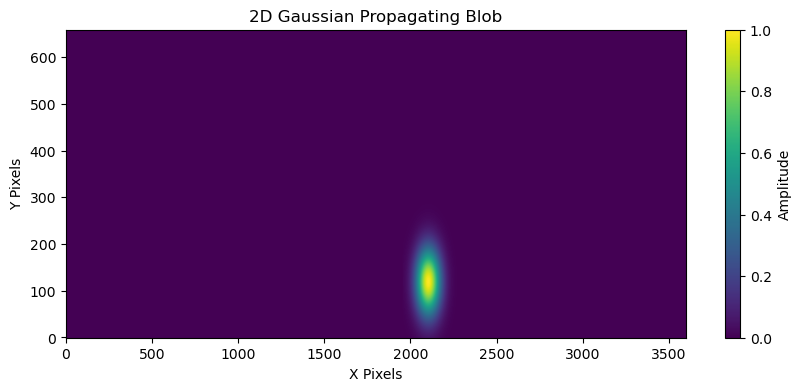

In [19]:
# Parameters for 2D Gaussian blob
npixel = [3600, 659]
avr = [150, 120]
st_dev = [50, 50]

# Generate the Gaussian wave
blob = gaussian_wave(npixel, avr, st_dev)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(blob.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('2D Gaussian Propagating Blob')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()


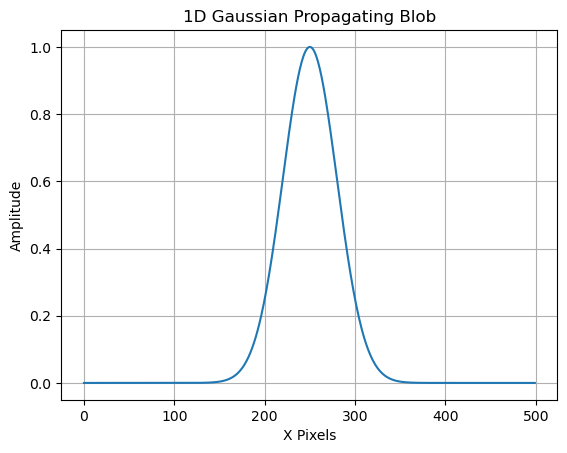

In [20]:
# Parameters for 1D Gaussian blob
npixel_1d = [500]
avr_1d = [250]
st_dev_1d = [30]

# Generate the Gaussian wave
blob_1d = gaussian_wave(npixel_1d, avr_1d, st_dev_1d)

# Plot
plt.figure()
plt.plot(blob_1d)
plt.title('1D Gaussian Propagating Blob')
plt.xlabel('X Pixels')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


# Funtion responsible for generating multiple Gaussian blobs at different position angles in order to create synthetic solar image

In [21]:
def syncom_image(params, syncom_version, time_0, radial_i, v_array,
                 period_array, L_array, PSI, time_t):
    """
    Generates a synthetic solar wind image at a given time step.

    Parameters:
        ModPramsStruct: dict-like object with keys 'SYNCOM_NX', 'SYNCOM_NY', 'SYNCOM_N_BLOBS'
        syncom_version: string identifier for simulation version
        time_0: initial time offset (in frames)
        radial_i: array of initial radial positions [pixels]
        v_array: array of radial velocities [pixels/frame]
        period_array: array of blob periods [seconds]
        L_array: array of blob sizes [degrees]
        PSI: array of position angles [degrees]
        time_t: current time step [frames]

    Returns:
        img: 2D NumPy array representing the synthetic image
    """
#     import time
    start_time = time.time()
    
    n_blobs = params["syncom_n_blobs"]
    NX = params["syncom_nx"]
    NY = params["syncom_ny"]

    radial_t = (time_t + time_0) * v_array  # pixel positions at time_t

    img = np.zeros((NX, NY), dtype=float)

    for i in range(n_blobs):
        # Create base Gaussian blob
        a_arr = gaussian_wave(
            npixel=[NX, NY],
            avr=[PSI[i], radial_i[i]],
            st_dev=[L_array[i], 2 * L_array[i]]
        )

        # Add repeated/perturbed blobs at harmonic intervals
        for n in [2, 4, 6, -2, -4, -6]:
            shift_amount = int(n * period_array[i] * v_array[i] + n * L_array[i])
            a_arr += np.roll(a_arr, shift=shift_amount, axis=1)

        # Shift for radial displacement over time
        a_arr = np.roll(a_arr, shift=int(radial_t[i]), axis=1)

        # Add to final image
        img += a_arr

    # Save image to FITS
    filename = f"SynCOM_{syncom_version}_{time_t}.fts"
    fits.writeto(filename, img, overwrite=True)

    print(f"Run time for step {time.time() - start_time} s")

    return img


## Examples of how to create a mock solar image witn random parameters

In [24]:

# Example arrays (replace with actual values from your simulation)
syncom_version = 'v1'
time_0 = 499
radial_i = outarray[:, 0] / pixel_size
v_array = (outarray[:, 5] * cadence) / spatial_scale
period_array = outarray[:, 4]
L_array = scale_factor * outarray[:, 6] / 0.1
PSI = outarray[:, 7]
time_t = 500


# Generate image
img = syncom_image(params, syncom_version, time_0, radial_i,
                   v_array, period_array, L_array, PSI, time_t)


Run time for step 118.98045921325684 s


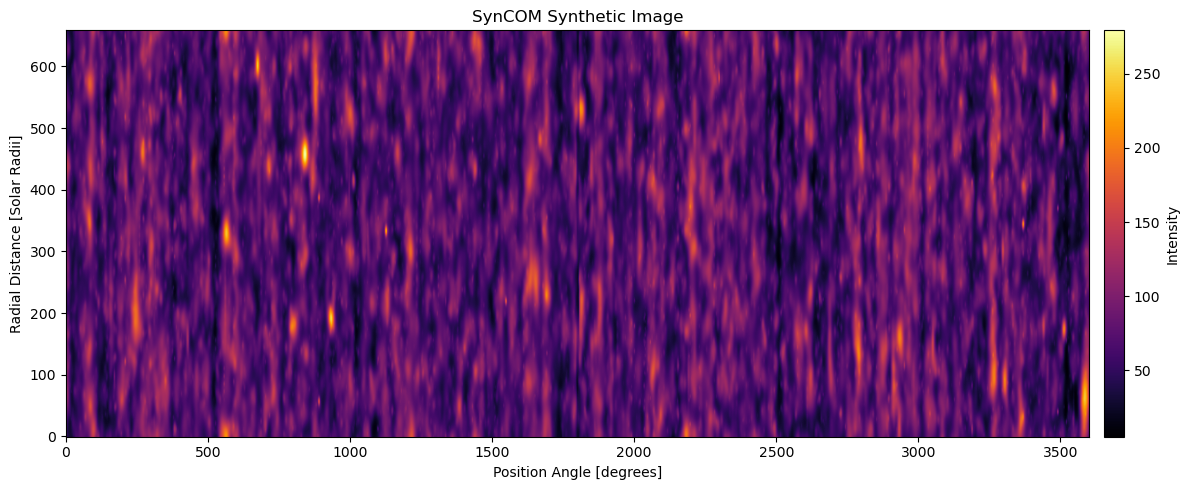

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_syncom_image(img, title="SynCOM Synthetic Image", cmap='inferno'):
    """
    Plots the 2D synthetic solar wind image with a tight colorbar.

    Parameters:
        img (np.ndarray): 2D image array
        title (str): Plot title
        cmap (str): Matplotlib colormap
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    im = ax.imshow(img.T, origin='lower', aspect='auto', cmap=cmap)
    
    # Divider to attach the colorbar tightly to the image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.15)  # smaller pad brings it closer
    
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Intensity')

    ax.set_title(title)
    ax.set_xlabel('Position Angle [degrees]')
    ax.set_ylabel('Radial Distance [Solar Radii]')

    plt.tight_layout()
    plt.show()
    
    
plot_syncom_image(img)

In [27]:
# import time
# import numpy as np

def syncom_core(
    N_BLOBS,
    time0,
    time_t,
    syncom_version="v1",
    scale_factor=None,
    simple=False,
    save=False,
    params=None,
    LoadStruc=None
):
    """
    Simulates the solar wind outflow using SynCOM and produces a time-dependent image cube.

    Parameters:
        N_BLOBS (int): Number of blobs to simulate
        time0 (int): Starting time step
        time_t (int): Ending time step (exclusive)
        syncom_version (str): Optional label/version for saving
        scale_factor (float): Blob size scaling factor
        simple (bool): Use sinusoidal velocity profile if True
        save (bool): Save output as compressed npz
        params (dict): Model parameters
        LoadStruc (dict): Precomputed blob data

    Returns:
        syncom_data (np.ndarray): 3D synthetic image cube [NX, NY, time_t - time0]
    """
    start_time = time.time()

    # 1. Validate and extract parameters
    if params is None:
        raise ValueError("params dictionary must be provided.")

    nx = params["syncom_nx"]
    ny = params["syncom_ny"]
    cadence = params["syncom_cadence"]
    pixel_size = params["syncom_pixel"]
    scalefactor = scale_factor if scale_factor is not None else params["syncom_scale_factor"]
    params["syncom_scale_factor"] = scalefactor

    # 2. Load or use provided blob structure
    if LoadStruc is None:
        LoadStruc = syncom_load(params, simple=simple)

    outarray = LoadStruc["outarray"]

    # 3. Unit conversions and property extraction
    Rsun2Km = 696000.0
    spatial_scale = Rsun2Km * pixel_size
    n_blobs = N_BLOBS

    rng = np.random.default_rng(22)
    time_0 = rng.uniform(1.0, 201.0, n_blobs)
    radial_i = outarray[:, 0] / pixel_size
    period_array = outarray[:, 4]
    v_array = (outarray[:, 5] * cadence) / spatial_scale  # pixels/frame
    L_array = scalefactor * outarray[:, 6] / 0.1
    PSI = outarray[:, 7]

    # 4. Prepare output cube
    nt = time_t - time0
    syncom_data = np.zeros((nx, ny, nt), dtype=float)

    # 5. Run simulation loop
    for t in range(time0, time_t):
        img = syncom_image(params, syncom_version, time_0, radial_i,
                   v_array, period_array, L_array, PSI, t)
#         img = syncom_image(
#             params=params,
#             syncom_version=syncom_version,
#             time_0=time_0,
#             radial_i=radial_i,
#             v_array=v_array,
#             period_array=period_array,
#             L_array=L_array,
#             PSI=PSI,
#             time_t=t
#         )
        syncom_data[:, :, t - time0] = img

    # 6. Optionally save output
    if save:
        output_name = f"SynCOM_{syncom_version}_cube.npz"
        np.savez_compressed(
            output_name,
            syncom_data=syncom_data,
            params=params,
            LoadStruc=LoadStruc,
            scale_factor=scalefactor
        )
        print(f"✅ Saved: {output_name}")

    print(f"⏱️ Total runtime: {time.time() - start_time} seconds")
    return syncom_data


In [28]:
# Step 1: Load SynCOM parameters
params = default_syncom_prams(SYNCOM_N_BLOBS=5000,DATE="2023-04-11", SAVEPRAMS="syncom_params.npy")

# Step 2: Run the simulation from time step 0 to 5
cube = syncom_core(
    N_BLOBS=5000,            # Number of blobs
    time0=200,                 # Starting time index
    time_t=220,                # Ending time index (exclusive)
    syncom_version="v1",    # Label for output files
    scale_factor=1.0,       # Optional override for blob size scaling
    simple=True,           # Use real (not sinusoidal) velocity profile
    save=True,              # Save the result as .npz
    params=params           # Parameter dictionary
)


Saved SYNCOM parameters to: syncom_params.npy
Run time for step 118.36400413513184 s
Run time for step 117.4120671749115 s
Run time for step 118.29008793830872 s
Run time for step 118.51858592033386 s
Run time for step 117.31871700286865 s
Run time for step 117.79209089279175 s
Run time for step 117.26536011695862 s
Run time for step 119.48939800262451 s
Run time for step 117.90037608146667 s
Run time for step 117.95983004570007 s
Run time for step 118.39219307899475 s
Run time for step 118.40542125701904 s
Run time for step 118.96286511421204 s
Run time for step 118.29559326171875 s
Run time for step 117.2712471485138 s
Run time for step 118.86207890510559 s
Run time for step 116.92482113838196 s
Run time for step 117.62857508659363 s
Run time for step 117.51613426208496 s
Run time for step 118.94761300086975 s
✅ Saved: SynCOM_v1_cube.npz
⏱️ Total runtime: 2373.0225751399994 seconds


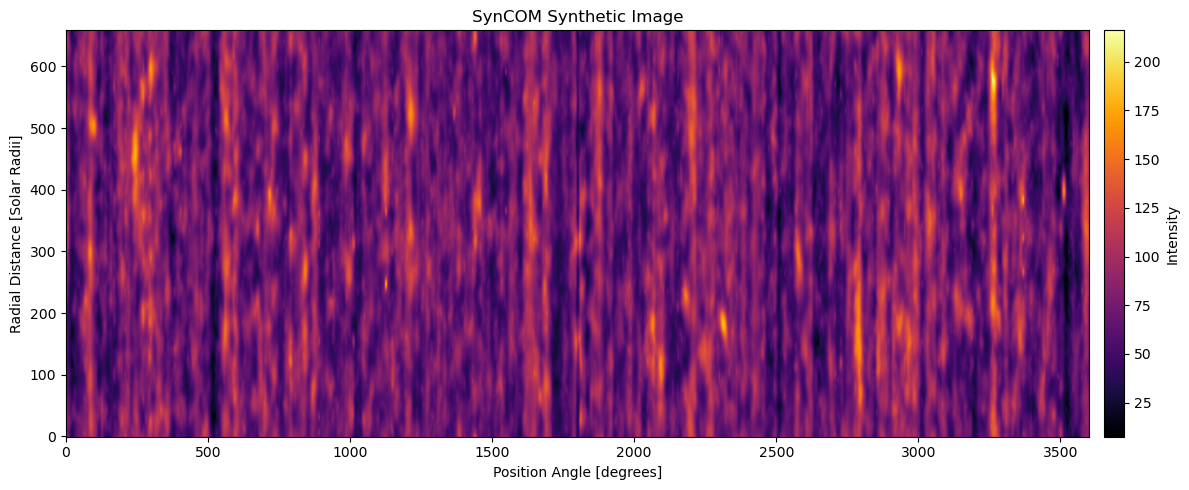

In [30]:
plot_syncom_image(cube[:,:,0])

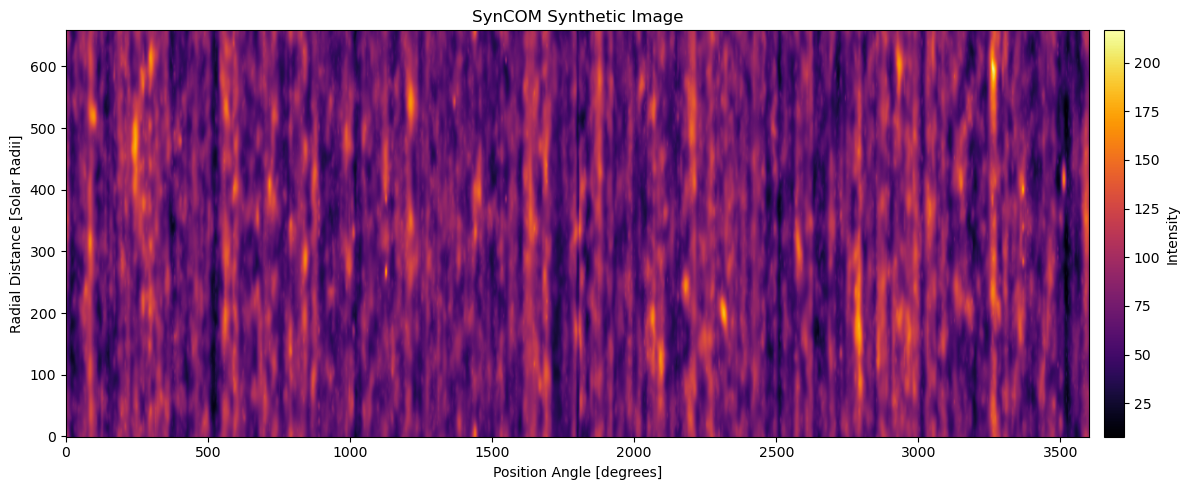

In [31]:
plot_syncom_image(cube[:,:,4])

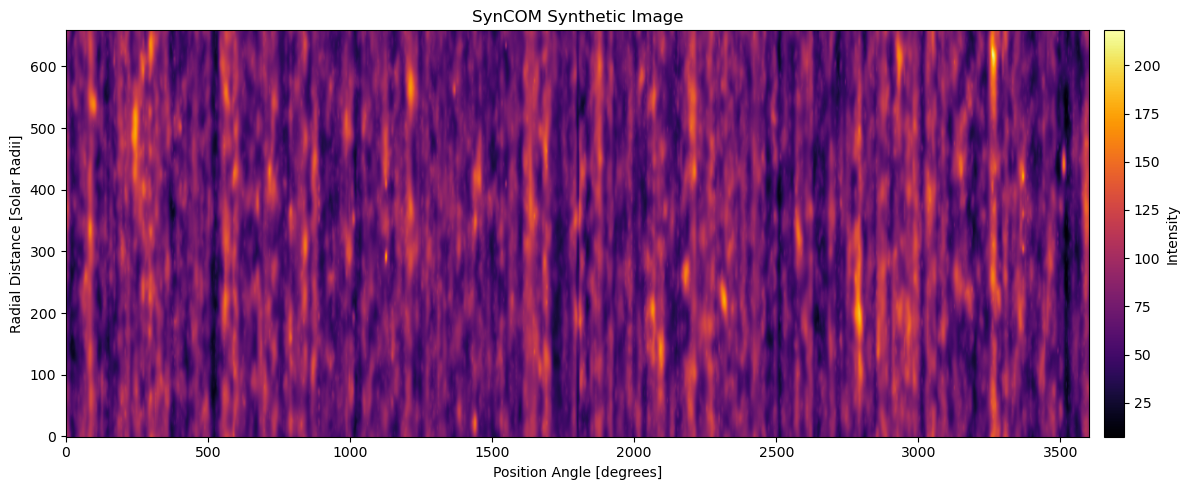

In [32]:
plot_syncom_image(cube[:,:,9])

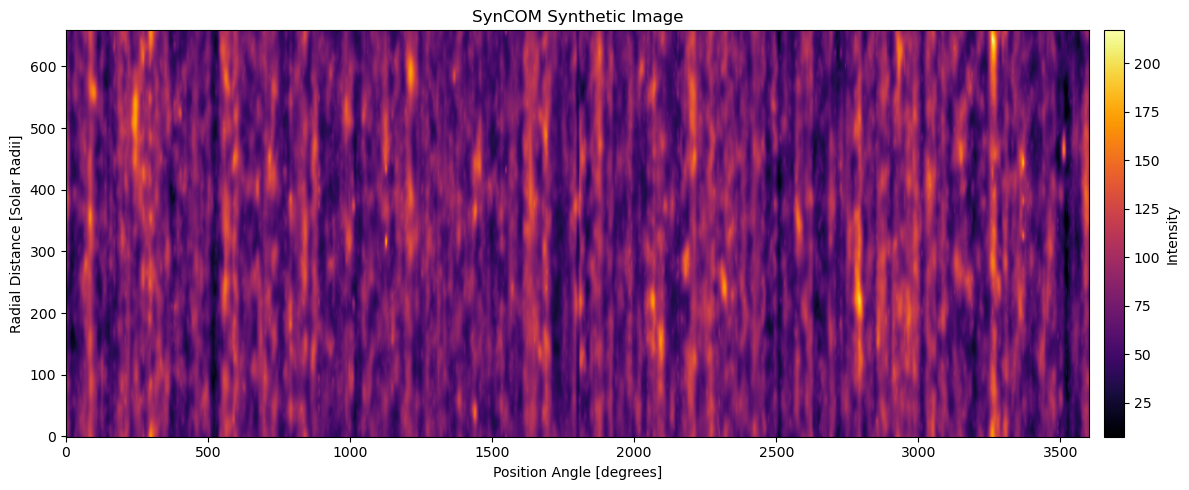

In [33]:
plot_syncom_image(cube[:,:,14])

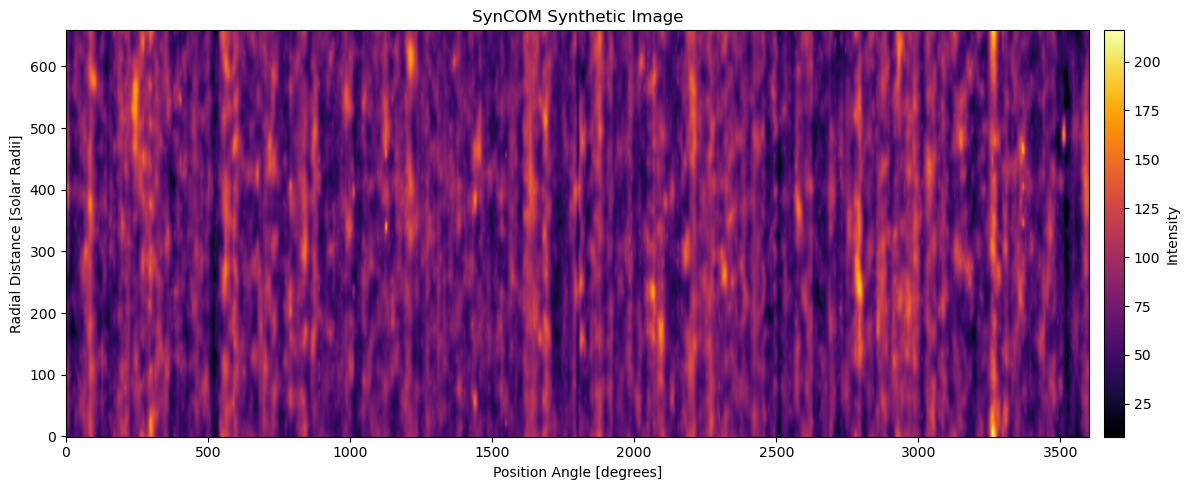

In [34]:
plot_syncom_image(cube[:,:,19])